In [2]:
library(ggplot2)
library(dplyr)
library(lme4)
library(lmerTest)
library(glmmTMB)
library(cowplot)
library(grid)
library(patchwork)

pallette = c("#318480", "#b4464f")
pallette2 = c("#052F5F", "#DA9307")
pallette2[[1]]

ignore = c("augment_tied")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix


Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step



Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots




[1] "#052F5F"

# Humphreys & Bock 2005

In [4]:
hb_df <- read.csv("../evalsets/HumphreysBock2005/items.csv.reformat")


hb_df <- tidyr::separate(hb_df, condition, c("subj", "local", "prep"), sep=1:3)
hb_df$type <- substr(hb_df$model, 5, nchar(hb_df$model) - 1)
hb_df[hb_df$model == "gpt2",]$type <- "gpt2"
hb_df$model <- as.factor(hb_df$model)
hb_df <- subset(hb_df, hb_df$subj == "C" & hb_df$local == "P")
hb_df$prep <- as.factor(hb_df$prep)


coding_matrix <- matrix(c(1, -1), ncol=1)
contrasts(hb_df$prep) <- coding_matrix

hb_means <- hb_df %>% group_by(type, prep) %>% 
                        summarize(sample = mean(sample), max = mean(max))

hb_human <- data.frame(type=c("h", "h"),
                       prep=c("C", "D"),
                       sample=c(67,75))
hb_human$max = hb_human$sample

hb_means = rbind(hb_means, hb_human)
hb_means

hb_means <- subset(hb_means, !(hb_means$type %in% ignore))


`summarise()` has grouped output by 'type'. You can override using the `.groups` argument.


type,prep,sample,max
<chr>,<chr>,<dbl>,<dbl>
augment,C,68.52470,87.77778
augment,D,70.11411,87.77778
augment_tied,C,71.64623,91.66667
augment_tied,D,71.34206,94.44444
gpt2,C,32.99236,16.66667
gpt2,D,33.66023,16.66667
lmaug,C,70.73067,94.44444
lmaug,D,68.99882,86.66667
wiki_lm,C,78.88966,100.00000


No summary function supplied, defaulting to `mean_se()`

No summary function supplied, defaulting to `mean_se()`

No summary function supplied, defaulting to `mean_se()`

No summary function supplied, defaulting to `mean_se()`



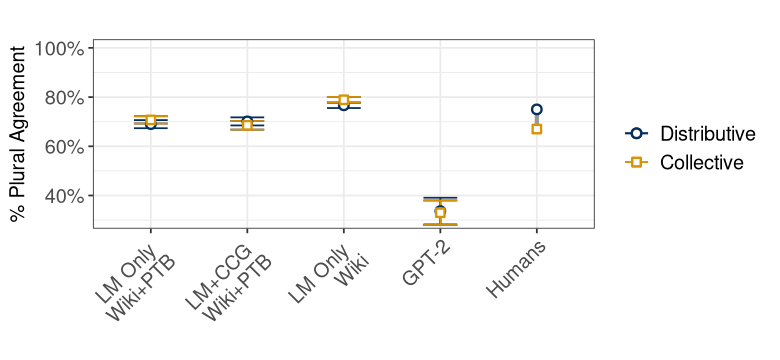

In [7]:
options(repr.plot.width=6.5, repr.plot.height=3)
model_order = c("lmaug", "augment", "wiki_lm", "gpt2", "h")

# no lmwiki results in plot
hb_means <- subset(hb_means, type != "w")
hb_df <- subset(hb_df, type != "w")

hb_means$type <- factor(hb_means$type, levels=model_order)
hb_df$type <- factor(hb_df$type, levels=model_order)

ggplot(data=hb_means, aes(x=factor(type, levels=model_order), y=sample/100)) +
geom_point(data=subset(hb_means, prep=="D"), shape=21, size=2, color=pallette2[[1]], fill="#FFFFFF") +
stat_summary(data=subset(hb_df, prep="D"), geom="errorbar", width=0.35, 
                         aes(x=factor(type, levels=model_order), group=prep, color="D")) +
stat_summary(data=subset(hb_df, prep=="C"), geom="errorbar", width=0.35,  
                         aes(x=factor(type, levels=model_order), group=prep, color="C")) +
geom_line(data=hb_means, position=position_dodge(width=0.5), size=1.2, color="#999999") +
geom_point(data=subset(hb_means, prep=="D"), aes(shape="D", color="D"), size=2, stroke=1, fill="#FFFFFF") +
geom_point(data=subset(hb_means, prep=="C"), aes(shape="C", color="C"), size=2, stroke=1, fill="#FFFFFF") + 
labs(x="", manip="", y="% Plural Agreement", title="") +
scale_y_continuous(labels=scales::percent) +
scale_x_discrete(labels=c("lmaug"="LM Only \nWiki+PTB",
                          "augment"="LM+CCG \nWiki+PTB",
                          "wiki_lm"="LM Only \nWiki",
                          "ccglm"="LM Only \nPTB",
                          "gpt2"="GPT-2",
                          "h"="Humans")) +
scale_color_manual(name="",
                   labels=c("D"="Distributive",
                            "C"="Collective"),
                     values=c("D"=pallette2[[1]],
                             "C"=pallette2[[2]])) +
scale_shape_manual(name="",
                   labels=c("D"="Distributive", 
                            "C"="Collective"),
                   values=c("D"=21,"C"=22)) +
coord_cartesian(ylim = c(0.3,1.0)) +
theme_bw() +
theme(axis.text.x=element_text(size=12, angle=45, hjust=1), axis.text.y=element_text(size=12),
      axis.title.y=element_text(size=12), axis.title.x=element_text(size=10),
      strip.text=element_text(size=12), legend.text=element_text(size=12))

ggsave("plots/Humphreys_all.png", width=6.5, height=3)

In [67]:
hb_lm <- glmmTMB(data=subset(hb_df, type=="lmaug"), 
                  sample/100 ~ prep + (1 | item) + (1 | model),
                 family=beta_family())
summary(hb_lm)

hb_a <- glmmTMB(data=subset(hb_df, type=="augment"), 
                  sample/100 ~ prep + (1 | item) + (1 | model),
                 family=beta_family())
summary(hb_a)


hb_w <- glmmTMB(data=subset(hb_df, type=="wiki_lm"), 
                  sample/100 ~ prep + (1 | item) + (1 | model),
                 family=beta_family())
summary(hb_w)

hb_g <- glmmTMB(data=subset(hb_df, type=="gpt2"), 
                  sample/100 ~ prep + (1 | item),
                 family=beta_family())
summary(hb_g)

hb <- glmmTMB(data=hb_df, 
                  sample/100 ~ prep * type + (1 | item) + (1 | model),
                 family=beta_family())

summary(hb)

 Family: beta  ( logit )
Formula:          sample/100 ~ prep + (1 | item) + (1 | model)
Data: subset(hb_df, type == "lmaug")

     AIC      BIC   logLik deviance df.resid 
  -286.9   -270.9    148.4   -296.9      175 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev.
 item   (Intercept) 0.1353   0.3678  
 model  (Intercept) 0.1628   0.4035  
Number of obs: 180, groups:  item, 18; model, 5

Dispersion parameter for beta family (): 20.9 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.88953    0.20348   4.371 1.23e-05 ***
prep1        0.04657    0.03531   1.319    0.187    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

 Family: beta  ( logit )
Formula:          sample/100 ~ prep + (1 | item) + (1 | model)
Data: subset(hb_df, type == "augment")

     AIC      BIC   logLik deviance df.resid 
  -196.3   -180.3    103.2   -206.3      175 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev.
 item   (Intercept) 0.165169 0.4064  
 model  (Intercept) 0.007345 0.0857  
Number of obs: 180, groups:  item, 18; model, 5

Dispersion parameter for beta family (): 11.1 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.83507    0.11360   7.351 1.96e-13 ***
prep1       -0.02992    0.04625  -0.647    0.518    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

 Family: beta  ( logit )
Formula:          sample/100 ~ prep + (1 | item) + (1 | model)
Data: subset(hb_df, type == "wiki_lm")

     AIC      BIC   logLik deviance df.resid 
  -390.4   -374.5    200.2   -400.4      175 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev.
 item   (Intercept) 0.06456  0.2541  
 model  (Intercept) 0.14105  0.3756  
Number of obs: 180, groups:  item, 18; model, 5

Dispersion parameter for beta family (): 29.5 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.30711    0.18153   7.201    6e-13 ***
prep1        0.07251    0.03248   2.232   0.0256 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

 Family: beta  ( logit )
Formula:          sample/100 ~ prep + (1 | item)
Data: subset(hb_df, type == "gpt2")

     AIC      BIC   logLik deviance df.resid 
   -26.0    -19.7     17.0    -34.0       32 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev.
 item   (Intercept) 0.8993   0.9483  
Number of obs: 36, groups:  item, 18

Dispersion parameter for beta family (): 21.5 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept) -0.75811    0.23834  -3.181  0.00147 **
prep1       -0.01706    0.08026  -0.213  0.83166   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

 Family: beta  ( logit )
Formula:          sample/100 ~ prep * type + (1 | item) + (1 | model)
Data: hb_df

     AIC      BIC   logLik deviance df.resid 
 -1022.1   -962.6    524.1  -1048.1      707 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev.
 item   (Intercept) 0.09929  0.3151  
 model  (Intercept) 0.06958  0.2638  
Number of obs: 720, groups:  item, 18; model, 20

Dispersion parameter for beta family (): 13.7 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)             0.85253    0.14568   5.852 4.85e-09 ***
prep1                  -0.02716    0.04201  -0.646   0.5180    
typeaugment_tied        0.08032    0.18803   0.427   0.6693    
typegpt2               -1.54481    0.30570  -5.053 4.34e-07 ***
typelmaug               0.01148    0.17727   0.065   0.9484    
typewiki_lm             0.39588    0.17804   2.224   0.0262 *  
prep1:typeaugment_tied  0.03920    0.06354   0.617   0.5373    
prep1:typegpt2      

# Parker & An 2018

In [2]:
ignore = c("augment_tied", "wiki_lm")

pa_df <- read.csv("../evalsets/ParkerAn2018/items.comp.csv.reformatc")

pa_df$type <- substr(pa_df$model,5, nchar(pa_df$model) - 1)
unique(pa_df$model)
pa_df[pa_df$model == "gpt2",]$type <- "gpt2"
pa_df$type <- as.factor(pa_df$type)

pa_df <- tidyr::separate(pa_df, condition, c("argument", "attr", "gram"), sep="_")

coding_matrix <- matrix(c(1, -1), ncol=1)
pa_df$argument <- as.factor(pa_df$argument)
pa_df$attr <- as.factor(pa_df$attr)
pa_df$gram <- as.factor(pa_df$gram)

contrasts(pa_df$argument) <- coding_matrix
contrasts(pa_df$attr) <- coding_matrix
contrasts(pa_df$gram) <- coding_matrix
pa_df <- tidyr::gather(pa_df, "pos", "surp", starts_with("surp_pos"))
pa_df$pos <- as.numeric(substr(pa_df$pos, 10,10))

pa_df$pos_adj <- mapply(function(x, y) {
    return(ifelse(x == "CORE" & y > 2, y + 2, y + 1))
}, pa_df$argument, pa_df$pos)

pa_df$pos_adj <- as.numeric(lapply(pa_df$pos_adj, function(x) return(ifelse(x > 9, NA, x))))
pa_df <- subset(pa_df, !is.na(pa_df$pos_adj))
pa_df
                                   
# For lmer
pa_df_verb <- subset(pa_df, pos_adj== 8)
pa_df_verb

[1] "lstmlmaug0"        "lstmlmaug1"        "lstmlmaug2"       
 [4] "lstmlmaug3"        "lstmlmaug4"        "lstmaugment0"     
 [7] "lstmaugment1"      "lstmaugment2"      "lstmaugment3"     
[10] "lstmaugment4"      "lstmwiki_lm0"      "lstmwiki_lm1"     
[13] "lstmwiki_lm2"      "lstmwiki_lm3"      "lstmwiki_lm4"     
[16] "lstmaugment_tied0" "lstmaugment_tied1" "lstmaugment_tied2"
[19] "lstmaugment_tied3" "gpt2"

,X,item,argument,attr,gram,model,len,type,pos,surp,pos_adj
,<int>,<int>,<fct>,<fct>,<fct>,<chr>,<int>,<fct>,<dbl>,<dbl>,<dbl>
1,0,0,OBLIQUE,S,G,lstmlmaug0,14,lmaug,0,12.90838,1
2,1,0,OBLIQUE,S,G,lstmlmaug1,14,lmaug,0,12.68866,1
3,2,0,OBLIQUE,S,G,lstmlmaug2,14,lmaug,0,12.66669,1
4,3,0,OBLIQUE,S,G,lstmlmaug3,14,lmaug,0,12.56073,1
5,4,0,OBLIQUE,S,G,lstmlmaug4,14,lmaug,0,12.60944,1
6,5,0,OBLIQUE,S,G,lstmaugment0,14,augment,0,12.12772,1
7,6,0,OBLIQUE,S,G,lstmaugment1,14,augment,0,12.44468,1
8,7,0,OBLIQUE,S,G,lstmaugment2,14,augment,0,12.20644,1
9,8,0,OBLIQUE,S,G,lstmaugment3,14,augment,0,12.52382,1


,X,item,argument,attr,gram,model,len,type,pos,surp,pos_adj
,<int>,<int>,<fct>,<fct>,<fct>,<chr>,<int>,<fct>,<dbl>,<dbl>,<dbl>
46121,40,0,CORE,S,G,lstmlmaug0,13,lmaug,6,4.328019,8
46122,41,0,CORE,S,G,lstmlmaug1,13,lmaug,6,5.724587,8
46123,42,0,CORE,S,G,lstmlmaug2,13,lmaug,6,4.750361,8
46124,43,0,CORE,S,G,lstmlmaug3,13,lmaug,6,5.999270,8
46125,44,0,CORE,S,G,lstmlmaug4,13,lmaug,6,4.479827,8
46126,45,0,CORE,S,G,lstmaugment0,13,augment,6,6.066065,8
46127,46,0,CORE,S,G,lstmaugment1,13,augment,6,4.994210,8
46128,47,0,CORE,S,G,lstmaugment2,13,augment,6,4.244129,8
46129,48,0,CORE,S,G,lstmaugment3,13,augment,6,6.755114,8


In [3]:
options(repr.plot.width=8, repr.plot.height=5)


pa_df_strip <- pa_df %>% group_by(item, argument, attr, gram, pos_adj, model, type) %>%
                         summarize(surp=mean(surp))

pa_u_human <- data.frame(item=rep(0, 16),
                         pos_adj=rep(c(7, 8 ,9 ,10), 4),
                         gram=rep(c("U"),16),
                         type=rep(c("h"),16),
                         model=rep(c("human"),16),
                         attr=rep(c(rep(c("S"), 4), rep(c("P"), 4)),2),
                         argument=rep(c(rep(c("OBLIQUE"), 8), rep(c("CORE"), 8))),
                         surp=c(340, 331, 357, 340, 332, 327, 332, 313, 330, 343, 349, 321, 327, 343, 351, 326))
pa_g_human <- data.frame(item=rep(0, 16),
                         pos_adj=rep(c(7, 8, 9, 10), 4),
                         gram=rep(c("G"),16),
                         type=rep(c("h"),16),
                         model=rep(c("human"),16),
                         attr=rep(c(rep(c("S"), 4), rep(c("P"), 4)),2),
                         argument=rep(c(rep(c("OBLIQUE"), 8), rep(c("CORE"), 8))),
                         surp=c(355, 330, 326, 310, 349, 327, 317, 318, 351, 335, 314, 313, 331, 330, 313, 317))

pa_df <- rbind(pa_df_strip, pa_u_human, pa_g_human)
pa_df <- subset(pa_df, !(pa_df$type %in% ignore))

`summarise()` has grouped output by 'item', 'argument', 'attr', 'gram',
'pos_adj', 'model'. You can override using the `.groups` argument.


In [26]:
model_order = c("lmaug", "augment", "gpt2", "h")

plot_pa_spr_x_m <- function(dataset, verb, xlim, ylim, no_leg=FALSE) {
    plt <- ggplot(subset(dataset, type != "h"), aes(x=pos_adj, y=surp, color=attr, shape=attr, linetype=argument, group=interaction(attr, argument))) + 
    facet_grid(.~factor(type, levels=model_order), labeller=as_labeller(c("lmaug"="LM Only \nWiki+PTB",
                          "augment"="LM+CCG \nWiki+PTB",
                          "wiki_lm"="LM Only \nWiki",
                          "gpt2"="GPT-2",
                          "ccglm"="LM Only \nPTB",
                          "h"="Humans")), scales="free_y") +
    stat_summary(geom="point", size=2.3, fun.data=mean_se) +
    stat_summary(geom="line", fun.data=mean_se) +
    stat_summary(geom="errorbar", width=0.2, fun.data=mean_se, show.legend=FALSE) +
    labs(x="", y="Surprisal (bits)", color="", shape="", linetype="") +
    scale_color_manual(labels=c(P="Mismatch (\"...girls...\")", S="Match (\"...girl...\")"), values=pallette) +
    scale_shape_manual(labels=c(P="Mismatch (\"...girls...\")", S="Match (\"...girl...\")"), values=c("P"=15, "S"=16)) +
    scale_linetype_discrete(labels=c(CORE="Core Argument (RC)", OBLIQUE="Oblique Argument (PP)")) +
    scale_x_continuous(labels=c("The", "waitress", "who", "sat", "(near)", "the", "girl(s)", "unsurprisingly", verb, "unhappy", "about"), breaks=0:10, limits=c(0,10)) +
    coord_cartesian(ylim=ylim, xlim=xlim) +
    theme_bw() + 
    theme(axis.text.x=element_text(angle=0, size=12), axis.text.y=element_text(size=12),
          axis.title.y=element_text(size=12),
          strip.text=element_text(size=12), legend.text=element_text(size=8), 
          panel.grid.minor=element_blank())
    
    if (no_leg) {
        plt = plt + theme(legend.position="none")
    }
    plt
}
plot_pa_spr_x_h <- function(dataset, verb, xlim, ylim, no_leg=FALSE) {
    plt <- ggplot(subset(dataset, type == "h"), aes(x=pos_adj, y=surp, color=attr, shape=attr, linetype=argument, group=interaction(attr, argument))) + 
    facet_grid(.~factor(type, levels=model_order), labeller=as_labeller(c("lmaug"="LM Only \nWiki+PTB",
                          "augment"="LM+CCG \nWiki+PTB",
                          "wiki_lm"="LM Only \nWiki",
                          "ccglm"="LM Only \nPTB",
                          "h"="Humans")), scales="free_y") +
    stat_summary(geom="point", size=2.3, fun.data=mean_se) +
    stat_summary(geom="line", fun.data=mean_se) +
    stat_summary(geom="errorbar", width=0.2, fun.data=mean_se, show.legend=FALSE) +
    labs(x="", y="RT (ms)", color="", shape="", linetype="") +
    scale_color_manual(labels=c(P="Mismatch (\"...girls...\")", S="Match (\"...girl...\")"), values=pallette) +
    scale_shape_manual(labels=c(P="Mismatch (\"...girls...\")", S="Match (\"...girl...\")"), values=c("P"=15, "S"=16)) +
    scale_linetype_discrete(labels=c(CORE="Core Argument (RC)", OBLIQUE="Oblique Argument (PP)")) +
    scale_x_continuous(labels=c("The", "waitress", "who", "sat", "(near)", "the", "girl(s)", "unsurprisingly", verb, "unhappy", "about"), breaks=0:10, limits=c(0,10)) +
    scale_y_continuous(position="right") +
    coord_cartesian(ylim=ylim, xlim=xlim) +
    theme_bw() + 
    theme(axis.text.x=element_text(angle=0, size=12), axis.text.y=element_text(size=12),
          axis.title.y=element_text(size=12),
          strip.text=element_text(size=12), legend.text=element_text(size=8), panel.grid.minor=element_blank())
    
    if (no_leg) {
        plt = plt + theme(legend.position="none")
    }
    plt
}

plot_pa_spr_x <- function(dataset, verb, xlim_m, xlim_h, ylim_m, ylim_h) {
    plt_m <- plot_pa_spr_x_m(dataset, verb, xlim_m, ylim_m, no_leg=TRUE)
    plt_h <- plot_pa_spr_x_h(dataset, verb, xlim_h, ylim_h, no_leg=TRUE)
    plt_leg <- plot_pa_spr_x_m(dataset, verb, xlim_m, ylim_m) + theme(legend.position="bottom")
    leg <- get_legend(plt_leg)
    p1 <- cowplot::plot_grid(plt_m, plt_h)
    cowplot::plot_grid(p1, leg, rel_heights=c(1, 0.1), ncol=1)+ 
    theme(plot.background=element_rect(fill="white", color="white"))
}

[1] "gpt2"    "augment" "lmaug"   "h"

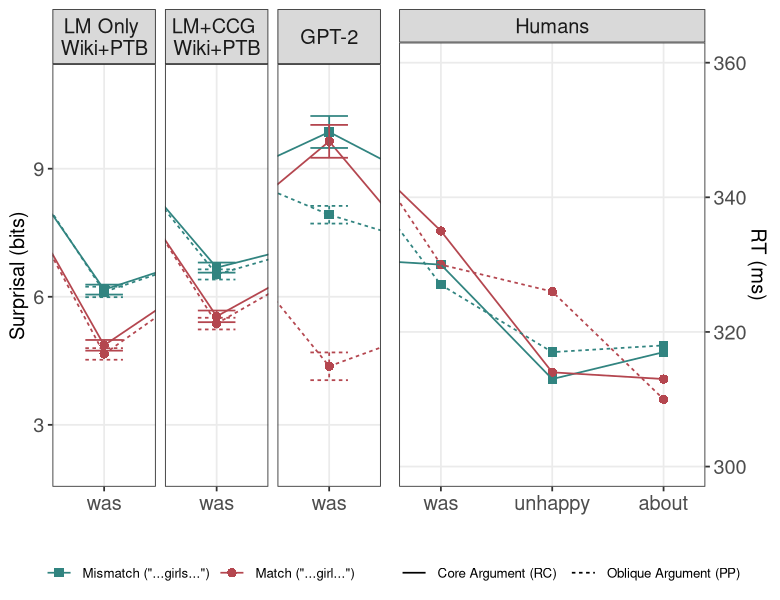

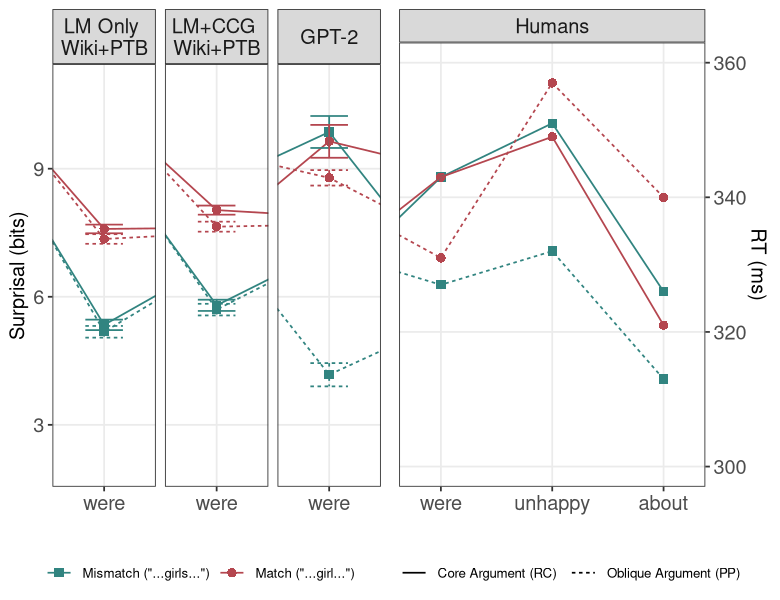

In [46]:
options(repr.plot.width=6.5, repr.plot.height=5)

unique(pa_df$type)

plot_pa_spr_x(subset(pa_df, gram=="G"), "was", c(7.75,8.25), c(7.75, 10.25), c(2,11), c(300, 360))
ggsave("plots/ParkerAn_G_popout.png", width= 6.5, height = 3.25)

plot_pa_spr_x(subset(pa_df, gram=="U"), "were", c(7.75,8.25), c(7.75, 10.25), c(2,11), c(300, 360)) 
ggsave("plots/ParkerAn_U_popout.png", width= 6.5, height = 3.25)

In [32]:

plot_pa_spr_y_m <- function(dataset, verb, xlim, ylim, no_leg=FALSE) {
    plt <- ggplot(subset(dataset, type != "h"), aes(x=pos_adj, y=surp, color=attr, shape=attr, linetype=argument, group=interaction(attr, argument))) + 
    facet_grid(factor(type, levels=model_order)~., labeller=as_labeller(c("lmaug"="LM Only \nWiki+PTB",
                          "augment"="LM+CCG \nWiki+PTB",
                          "wiki_lm"="LM Only \nWiki",
                          "ccglm"="LM Only \nPTB",
                          "gpt2"="GPT-2",
                          "h"="Humans"))) +
    stat_summary(geom="point", size=1.6, fun.data=mean_se) +
    stat_summary(geom="line", fun.data=mean_se) +
    stat_summary(geom="errorbar", width=0.3, fun.data=mean_se) +
    labs(x="", y="Surprisal (bits)", color="", linetype="", shape="") +
    scale_color_manual(labels=c(P="Mismatch (\"...girls...\")", S="Match (\"...girl...\")"), values=pallette) +
    scale_shape_manual(labels=c(P="Mismatch (\"...girls...\")", S="Match (\"...girl...\")"), values=c("P"=15, "S"=16)) + 
    scale_linetype_discrete(labels=c(CORE="Core Argument (RC)", OBLIQUE="Oblique Argument (PP)")) +
    scale_x_continuous(labels=c("The", "waitress", "who", "sat", "(near)", "the", "girl(s)", "unsurprisingly", verb, "unhappy", "about"), breaks=0:10, limits=c(0,10)) +
    coord_cartesian(ylim=ylim, xlim=xlim) +
    theme_bw() + 
    theme(axis.text.x=element_text(angle=45, hjust=1, size=12), axis.text.y=element_text(size=12),
          axis.title.y=element_text(size=12),
          strip.text=element_text(size=12, angle=0), legend.text=element_text(size=8), 
          panel.grid.minor=element_blank(),
          strip.text.y=element_text(angle=0), legend.position="top")
    
    if (no_leg) {
        plt = plt + theme(legend.position="none")
    }
    plt
}
plot_pa_spr_y_h <- function(dataset, verb, xlim, ylim, no_leg=FALSE) {
    plt <- ggplot(subset(dataset, type == "h"), aes(x=pos_adj, y=surp, color=attr, shape=attr, linetype=argument, group=interaction(attr, argument))) + 
    facet_grid(factor(type, levels=model_order)~., labeller=as_labeller(c("lmaug"="LM Only \nWiki+PTB",
                          "augment"="LM+CCG \nWiki+PTB",
                          "wiki_lm"="LM Only \nWiki",
                          "ccglm"="LM Only \nPTB",
                          "gpt2"="GPT-2",
                          "h"=" Humans "))) +
    stat_summary(geom="point", size=1.6, fun.data=mean_se) +
    stat_summary(geom="line", fun.data=mean_se) +
    stat_summary(geom="errorbar", width=0.3, fun.data=mean_se) +
    labs(x="", y="RT (ms)", color="", linetype="", shape="") +
    scale_color_manual(labels=c(P="Mismatch (\"...girls...\")", S="Match (\"...girl...\")"), values=pallette) +
    scale_shape_manual(labels=c(P="Mismatch (\"...girls...\")", S="Match (\"...girl...\")"), values=c("P"=15, "S"=16)) + 
    scale_linetype_discrete(labels=c(CORE="Core Argument (RC)", OBLIQUE="Oblique Argument (PP)")) +
    scale_x_continuous(labels=c("The", "waitress", "who", "sat", "(near)", "the", "girl(s)", "unsurprisingly", verb, "unhappy", "about"), breaks=0:10, limits=c(0,10)) +
    coord_cartesian(ylim=ylim, xlim=xlim) +
    theme_bw() + 
    theme(axis.text.x=element_text(angle=45, hjust=1, size=12), axis.text.y=element_text(size=12),
          axis.title.y=element_text(size=12),
          strip.text=element_text(size=12, angle=0), legend.text=element_text(size=8), 
          panel.grid.minor=element_blank(),
          strip.text.y=element_text(angle=0), legend.position="bottom")
    
    if (no_leg) {
        plt = plt + theme(legend.position="none")
    }
    plt
}

plot_pa_spr_y <- function(dataset, verb, ylim_m, ylim_h) {
    plt_m <- plot_pa_spr_y_m(dataset, verb, c(0,10), ylim_m)
    plt_h <- plot_pa_spr_y_h(dataset, verb, c(7,10.3), ylim_h, no_leg=TRUE)
    cowplot::plot_grid(plt_m, cowplot::plot_grid(NULL, plt_h, rel_widths=c(1, 0.87)), 
                       ncol=1, rel_heights=c(1, 0.55)) + 
    theme(plot.background=element_rect(fill="white", color="white"))

}

In [20]:
head(pa_df)

item,argument,attr,gram,pos_adj,model,type,surp
<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>
0,CORE,P,G,1,gpt2,gpt2,11.80449
0,CORE,P,G,1,lstmaugment0,augment,12.12772
0,CORE,P,G,1,lstmaugment1,augment,12.44468
0,CORE,P,G,1,lstmaugment2,augment,12.20644
0,CORE,P,G,1,lstmaugment3,augment,12.52382
0,CORE,P,G,1,lstmaugment4,augment,12.21255


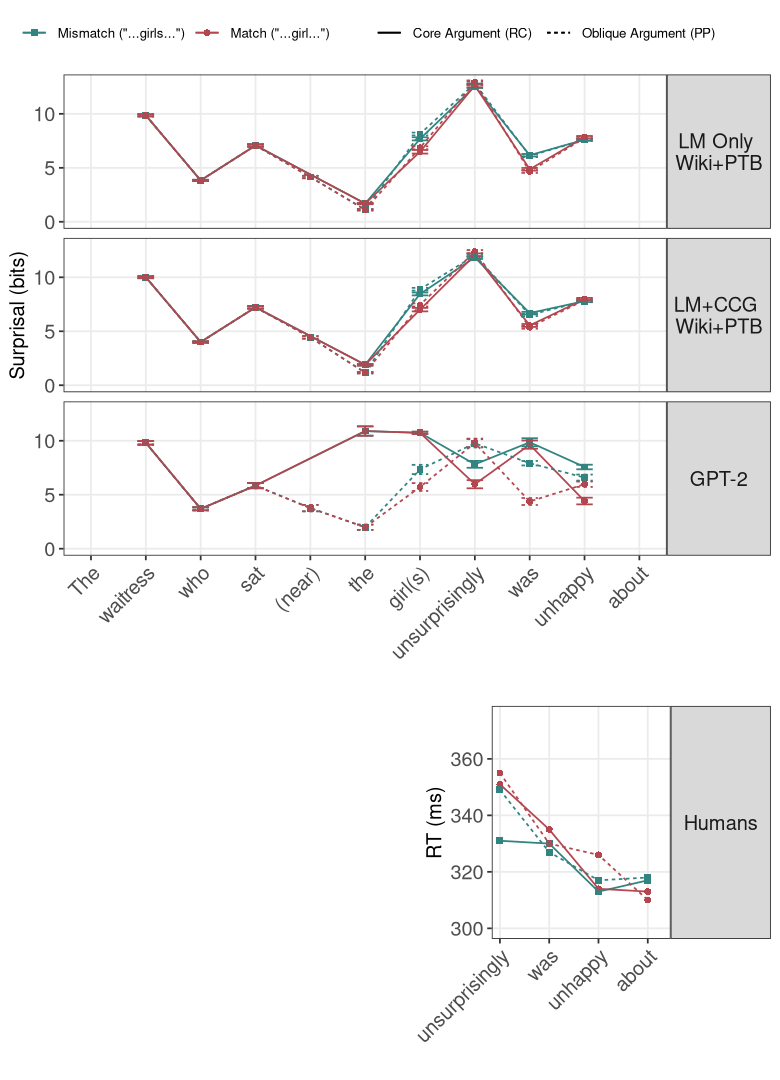

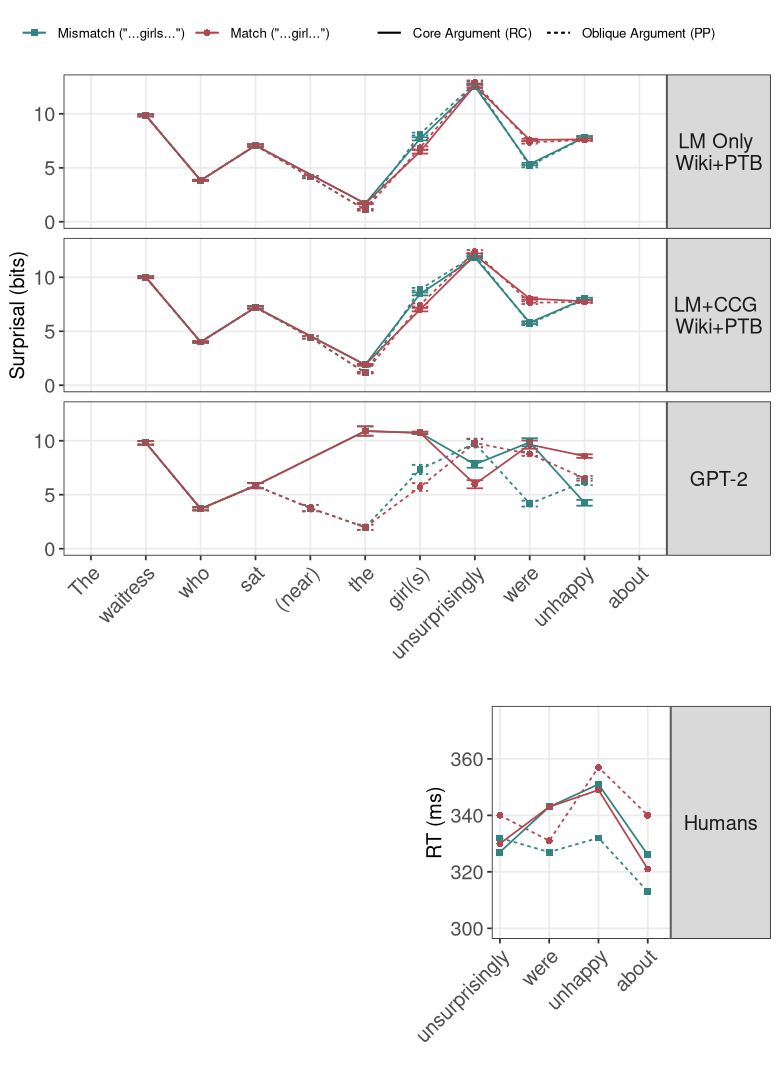

In [33]:
options(repr.plot.width=6.5, repr.plot.height=9)

plot_pa_spr_y(subset(pa_df, gram=="G"), "was", c(0,13), c(300,375))
ggsave("plots/Parker_G_full.png", width=6.5, height=7)


plot_pa_spr_y(subset(pa_df, gram=="U"), "were", c(0,13), c(300,375))
ggsave("plots/Parker_U_full.png", width=6.5, height=7)

In [63]:

print("grammatical")
pa_lm <- lmer(data=subset(pa_df_verb, pa_df_verb$type == "lmaug" & pa_df_verb$gram=="G"), 
                 surp ~ argument * attr  + (1|item) + (1 | model))

summary(pa_lm)

pa_lm <- lmer(data=subset(pa_df_verb, pa_df_verb$type == "lmaug" & pa_df_verb$gram=="U"), 
                 surp ~ argument * attr  + (1|item) + (1 | model))

summary(pa_lm)

print("ungram - obl")
pa_lm <- lmer(data=subset(pa_df_verb, pa_df_verb$type == "lmaug" & pa_df_verb$gram=="U" & argument=="OBLIQUE"), 
                 surp ~ attr  + (1|item) + (1 | model))

summary(pa_lm)

print("ungram - core")
pa_lm <- lmer(data=subset(pa_df_verb, pa_df_verb$type == "lmaug" & pa_df_verb$gram=="U" & argument=="CORE"), 
                 surp ~ attr  + (1|item) + (1 | model))

summary(pa_lm)

pa_lm <- lmer(data=subset(pa_df_verb, pa_df_verb$type == "augment" & pa_df_verb$gram=="G"), 
                 surp ~ argument * attr  + (1|item) + (1 | model))

summary(pa_lm)
pa_lm <- lmer(data=subset(pa_df_verb, pa_df_verb$type == "augment" & pa_df_verb$gram=="U"), 
                 surp ~ argument * attr  + (1|item) + (1 | model))

summary(pa_lm)

print("ungram - obl")
pa_lm <- lmer(data=subset(pa_df_verb, pa_df_verb$type == "augment" & pa_df_verb$gram=="U" & argument=="OBLIQUE"), 
                 surp ~ attr  + (1|item) + (1 | model))

summary(pa_lm)

print("ungram - core")
pa_lm <- lmer(data=subset(pa_df_verb, pa_df_verb$type == "augment" & pa_df_verb$gram=="U" & argument=="CORE"), 
                 surp ~ attr  + (1|item) + (1 | model))

summary(pa_lm)


pa_lm <- lmer(data=subset(pa_df_verb, pa_df_verb$gram=="G"), 
                 surp ~ argument * attr * type  + (1|item) + (1 | model))

summary(pa_lm)
              
pa_lm <- lmer(data=subset(pa_df_verb, pa_df_verb$gram=="U"), 
                 surp ~ argument * attr * type  + (1|item) + (1 | model))

summary(pa_lm)


pa_lm <- lmer(data=subset(pa_df_verb, pa_df_verb$gram=="G" & pa_df_verb$type == "gpt2"), 
                 surp ~ argument * attr + (1|item))

summary(pa_lm)
              
pa_lm <- lmer(data=subset(pa_df_verb, pa_df_verb$gram=="U" & pa_df_verb$type == "gpt2"), 
                 surp ~ argument * attr + (1|item))

summary(pa_lm)

[1] "grammatical"


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: surp ~ argument * attr + (1 | item) + (1 | model)
   Data: subset(pa_df_verb, pa_df_verb$type == "lmaug" & pa_df_verb$gram ==  
    "G")

REML criterion at convergence: 2733

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.59775 -0.68751 -0.04417  0.66756  3.11545 

Random effects:
 Groups   Name        Variance Std.Dev.
 item     (Intercept) 2.8911   1.7003  
 model    (Intercept) 0.1387   0.3725  
 Residual             0.7911   0.8895  
Number of obs: 960, groups:  item, 48; model, 5

Fixed effects:
                 Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)       5.45134    0.29800  27.82705  18.293   <2e-16 ***
argument1         0.06434    0.02871 904.99990   2.241   0.0253 *  
attr1             0.68907    0.02871 904.99990  24.003   <2e-16 ***
argument1:attr1  -0.03684    0.02871 904.99990  -1.283   0.1998    
---
Signif. codes:  0 '***' 0.001 '**'

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: surp ~ argument * attr + (1 | item) + (1 | model)
   Data: subset(pa_df_verb, pa_df_verb$type == "lmaug" & pa_df_verb$gram ==  
    "U")

REML criterion at convergence: 2805.3

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.99019 -0.69973  0.00064  0.66533  3.11969 

Random effects:
 Groups   Name        Variance Std.Dev.
 item     (Intercept) 2.4792   1.5745  
 model    (Intercept) 0.1175   0.3427  
 Residual             0.8642   0.9296  
Number of obs: 960, groups:  item, 48; model, 5

Fixed effects:
                 Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)       6.36598    0.27576  27.86562  23.085  < 2e-16 ***
argument1         0.09935    0.03000 905.00000   3.311 0.000966 ***
attr1            -1.10521    0.03000 905.00000 -36.835  < 2e-16 ***
argument1:attr1  -0.01846    0.03000 905.00000  -0.615 0.538584    
---
Signif. codes:  0 '***' 0.001 '*

[1] "ungram - obl"


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: surp ~ attr + (1 | item) + (1 | model)
   Data: subset(pa_df_verb, pa_df_verb$type == "lmaug" & pa_df_verb$gram ==  
    "U" & argument == "OBLIQUE")

REML criterion at convergence: 1458.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9208 -0.6757  0.0113  0.5856  2.9591 

Random effects:
 Groups   Name        Variance Std.Dev.
 item     (Intercept) 2.90529  1.7045  
 model    (Intercept) 0.09092  0.3015  
 Residual             0.83127  0.9117  
Number of obs: 480, groups:  item, 48; model, 5

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   6.26663    0.28362  35.62385   22.09   <2e-16 ***
attr1        -1.08675    0.04162 427.00022  -26.11   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
      (Intr)
attr1 0.000 

[1] "ungram - core"


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: surp ~ attr + (1 | item) + (1 | model)
   Data: subset(pa_df_verb, pa_df_verb$type == "lmaug" & pa_df_verb$gram ==  
    "U" & argument == "CORE")

REML criterion at convergence: 1422

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.58479 -0.70268 -0.00146  0.60528  2.80022 

Random effects:
 Groups   Name        Variance Std.Dev.
 item     (Intercept) 2.1601   1.4697  
 model    (Intercept) 0.1538   0.3922  
 Residual             0.7840   0.8855  
Number of obs: 480, groups:  item, 48; model, 5

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   6.46533    0.27822  19.40453   23.24 1.25e-15 ***
attr1        -1.12366    0.04042 427.00000  -27.80  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
      (Intr)
attr1 0.000 

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: surp ~ argument * attr + (1 | item) + (1 | model)
   Data: subset(pa_df_verb, pa_df_verb$type == "augment" & pa_df_verb$gram ==  
    "G")

REML criterion at convergence: 3170.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7755 -0.6615 -0.0528  0.6389  4.0115 

Random effects:
 Groups   Name        Variance Std.Dev.
 item     (Intercept) 2.1113   1.4530  
 model    (Intercept) 0.6803   0.8248  
 Residual             1.2939   1.1375  
Number of obs: 960, groups:  item, 48; model, 5

Fixed effects:
                  Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)       6.029608   0.425896   6.907237  14.157 2.34e-06 ***
argument1         0.082535   0.036712 905.000785   2.248   0.0248 *  
attr1             0.573298   0.036712 905.000785  15.616  < 2e-16 ***
argument1:attr1  -0.002357   0.036712 905.000785  -0.064   0.9488    
---
Signif. codes:  0 '***' 0.001 

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: surp ~ argument * attr + (1 | item) + (1 | model)
   Data: subset(pa_df_verb, pa_df_verb$type == "augment" & pa_df_verb$gram ==  
    "U")

REML criterion at convergence: 3168

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4551 -0.6671 -0.0333  0.6692  3.3833 

Random effects:
 Groups   Name        Variance Std.Dev.
 item     (Intercept) 1.8481   1.3595  
 model    (Intercept) 0.6728   0.8203  
 Residual             1.2989   1.1397  
Number of obs: 960, groups:  item, 48; model, 5

Fixed effects:
                 Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)       6.79266    0.41764   6.53930  16.264 1.56e-06 ***
argument1         0.12213    0.03678 904.99970   3.320 0.000936 ***
attr1            -1.04342    0.03678 904.99970 -28.366  < 2e-16 ***
argument1:attr1  -0.07189    0.03678 904.99970  -1.954 0.050976 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*

[1] "ungram - obl"


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: surp ~ attr + (1 | item) + (1 | model)
   Data: subset(pa_df_verb, pa_df_verb$type == "augment" & pa_df_verb$gram ==  
    "U" & argument == "OBLIQUE")

REML criterion at convergence: 1622.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8273 -0.6352 -0.0588  0.6138  3.4735 

Random effects:
 Groups   Name        Variance Std.Dev.
 item     (Intercept) 2.2433   1.4978  
 model    (Intercept) 0.5434   0.7371  
 Residual             1.2326   1.1102  
Number of obs: 480, groups:  item, 48; model, 5

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   6.67053    0.39746   7.93583   16.78 1.76e-07 ***
attr1        -0.97153    0.05067 426.99894  -19.17  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
      (Intr)
attr1 0.000 

[1] "ungram - core"


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: surp ~ attr + (1 | item) + (1 | model)
   Data: subset(pa_df_verb, pa_df_verb$type == "augment" & pa_df_verb$gram ==  
    "U" & argument == "CORE")

REML criterion at convergence: 1601.8

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.67047 -0.64016  0.07061  0.62543  2.97268 

Random effects:
 Groups   Name        Variance Std.Dev.
 item     (Intercept) 1.5689   1.2526  
 model    (Intercept) 0.8502   0.9221  
 Residual             1.2128   1.1013  
Number of obs: 480, groups:  item, 48; model, 5

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   6.91479    0.45305   5.63888   15.26 8.42e-06 ***
attr1        -1.11530    0.05027 427.00038  -22.19  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
      (Intr)
attr1 0.000 


Correlation matrix not shown by default, as p = 20 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: surp ~ argument * attr * type + (1 | item) + (1 | model)
   Data: subset(pa_df_verb, pa_df_verb$gram == "G")

REML criterion at convergence: 12325.3

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-12.5574  -0.5885  -0.0429   0.5545   6.7971 

Random effects:
 Groups   Name        Variance Std.Dev.
 item     (Intercept) 2.171    1.4735  
 model    (Intercept) 0.300    0.5477  
 Residual             1.323    1.1500  
Number of obs: 3840, groups:  item, 48; model, 20

Fixed effects:
                                   Estimate Std. Error         df t value
(Intercept)                       6.030e+00  3.265e-01  3.848e+01  18.466
argument1                         8.253e-02  3.712e-02  3.758e+03   2.224
attr1                             5.733e-01  3.712e-02  3.758e+03  15.446
typeaugment_tied                 -4.683e-01  3.716e-01  1.500e+01  -1.260
typegpt2                       


Correlation matrix not shown by default, as p = 20 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: surp ~ argument * attr * type + (1 | item) + (1 | model)
   Data: subset(pa_df_verb, pa_df_verb$gram == "U")

REML criterion at convergence: 12408.4

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-11.7550  -0.6053  -0.0426   0.5964   5.7096 

Random effects:
 Groups   Name        Variance Std.Dev.
 item     (Intercept) 1.9104   1.3822  
 model    (Intercept) 0.3117   0.5583  
 Residual             1.3541   1.1637  
Number of obs: 3840, groups:  item, 48; model, 20

Fixed effects:
                                   Estimate Std. Error         df t value
(Intercept)                       6.793e+00  3.218e-01  3.513e+01  21.109
argument1                         1.221e-01  3.756e-02  3.758e+03   3.252
attr1                            -1.043e+00  3.756e-02  3.758e+03 -27.782
typeaugment_tied                 -5.177e-01  3.787e-01  1.500e+01  -1.367
typegpt2                       

boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: surp ~ argument * attr + (1 | item)
   Data: subset(pa_df_verb, pa_df_verb$gram == "G" & pa_df_verb$type ==  
    "gpt2")

REML criterion at convergence: 866.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6977 -0.4719 -0.1467  0.3622  4.3113 

Random effects:
 Groups   Name        Variance Std.Dev.
 item     (Intercept) 0.000    0.00    
 Residual             5.244    2.29    
Number of obs: 192, groups:  item, 48

Fixed effects:
                Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)       7.9485     0.1653 188.0000  48.097  < 2e-16 ***
argument1         1.8017     0.1653 188.0000  10.902  < 2e-16 ***
attr1             0.9423     0.1653 188.0000   5.702 4.52e-08 ***
argument1:attr1  -0.8327     0.1653 188.0000  -5.039 1.09e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr) argmn

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: surp ~ argument * attr + (1 | item)
   Data: subset(pa_df_verb, pa_df_verb$gram == "U" & pa_df_verb$type ==  
    "gpt2")

REML criterion at convergence: 847.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8774 -0.4187 -0.1468  0.3454  3.4344 

Random effects:
 Groups   Name        Variance Std.Dev.
 item     (Intercept) 0.04062  0.2015  
 Residual             4.70899  2.1700  
Number of obs: 192, groups:  item, 48

Fixed effects:
                Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)       8.1151     0.1593  46.9997  50.946  < 2e-16 ***
argument1         1.6351     0.1566 140.9996  10.441  < 2e-16 ***
attr1            -1.0981     0.1566 140.9996  -7.012 8.97e-11 ***
argument1:attr1   1.2077     0.1566 140.9996   7.712 2.04e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr) argmn

# Wagers (2009)

In [2]:
wagers_df <- read.csv('../evalsets/Wagers2009/23_illusion/items.csv.reformatc')

wagers_df <- tidyr::separate(wagers_df, "condition", c("subj", "attr", "gram"), sep=c(1,2))
wagers_df <- tidyr::gather(wagers_df, "pos", "surp", starts_with("surp_pos"))
wagers_df$pos <- as.numeric(substr(wagers_df$pos, 10,10)) +1
wagers_df$match <- wagers_df$subj == wagers_df$attr
wagers_df$vmatch <- as.factor(xor(wagers_df$match, wagers_df$gram == "U"))

wagers_df$type <- substr(wagers_df$model,5, nchar(wagers_df$model)-1)
wagers_df[wagers_df$model == "gpt2",]$type <- "gpt2"
wagers_df$type <- as.factor(wagers_df$type)

wagers_df

X,item,subj,attr,gram,model,len,pos,surp,match,vmatch,type
<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<lgl>,<fct>,<fct>
0,0,S,S,U,lstmlmaug0,16,1,11.130884,TRUE,FALSE,lmaug
1,0,S,S,U,lstmlmaug1,16,1,10.788469,TRUE,FALSE,lmaug
2,0,S,S,U,lstmlmaug2,16,1,10.958960,TRUE,FALSE,lmaug
3,0,S,S,U,lstmlmaug3,16,1,11.102564,TRUE,FALSE,lmaug
4,0,S,S,U,lstmlmaug4,16,1,10.774361,TRUE,FALSE,lmaug
5,0,S,S,U,lstmaugment0,16,1,10.503095,TRUE,FALSE,augment
6,0,S,S,U,lstmaugment1,16,1,10.414978,TRUE,FALSE,augment
7,0,S,S,U,lstmaugment2,16,1,10.960505,TRUE,FALSE,augment
8,0,S,S,U,lstmaugment3,16,1,11.037403,TRUE,FALSE,augment


In [3]:
options(repr.plot.width=8, repr.plot.height=5)


wagers_df_strip <- wagers_df %>% group_by(
    pos, gram, attr, subj, match, vmatch, surp, model, type) %>%
                                 summarize(surp=mean(surp))

wagers_s_human <- data.frame(pos=rep(c(4, 5 ,6, 7), 4),
                         subj=rep(c("S"), 16),
                         model=rep(c("human"), 16),
                         type= rep(c("h"), 16),
                         attr=rep(c(rep(c("S"), 4), rep(c("P"), 4)),2),
                         gram=rep(c(rep(c("G"), 8), rep(c("U"), 8))),
                         surp=c(327, 352, 348, 345, 331.5, 344, 356, 361, 326, 342, 415, 370.5, 331.5, 355, 386, 335.5))

wagers_p_human <- data.frame(pos=rep(c(4, 5 ,6, 7), 4),
                         subj= rep(c("P"), 16),
                         model=rep(c("human"), 16),
                         type= rep(c("h"), 16),
                         attr=rep(c(rep(c("S"), 4), rep(c("P"), 4)),2),
                         gram=rep(c(rep(c("G"), 8), rep(c("U"), 8))),
                         surp=c(328, 364, 355, 353, 357, 374, 358, 344, 328, 364.5, 410.5, 356.5, 335, 359, 402, 361.5))
wagers_s_human$match <- wagers_s_human$attr=="S"
wagers_p_human$match <- wagers_p_human$attr=="P"
wagers_s_human$vmatch <- factor(xor(wagers_s_human$match, wagers_s_human$gram == "U"))
wagers_p_human$vmatch <- factor(xor(wagers_p_human$match, wagers_p_human$gram == "U"))


wagers_all <- rbind(wagers_s_human, wagers_p_human, wagers_df_strip)


coding_matrix <- matrix(c(1, -1), ncol=1)
wagers_all$match <- as.factor(wagers_all$match)
wagers_all$vmatch <- as.factor(wagers_all$vmatch)
wagers_all$subj <- as.factor(wagers_all$subj)
wagers_all$gram <- as.factor(wagers_all$gram)

contrasts(wagers_all$match) <- coding_matrix
contrasts(wagers_all$vmatch) <- coding_matrix
contrasts(wagers_all$subj) <- coding_matrix
contrasts(wagers_all$gram) <- coding_matrix

wagers_all

`summarise()` has grouped output by 'pos', 'gram', 'attr', 'subj', 'match', 'vmatch', 'surp', 'model'. You can override using the `.groups` argument.


pos,subj,model,type,attr,gram,surp,match,vmatch
<dbl>,<fct>,<chr>,<chr>,<chr>,<fct>,<dbl>,<fct>,<fct>
4,S,human,h,S,G,327.0,TRUE,TRUE
5,S,human,h,S,G,352.0,TRUE,TRUE
6,S,human,h,S,G,348.0,TRUE,TRUE
7,S,human,h,S,G,345.0,TRUE,TRUE
4,S,human,h,P,G,331.5,FALSE,FALSE
5,S,human,h,P,G,344.0,FALSE,FALSE
6,S,human,h,P,G,356.0,FALSE,FALSE
7,S,human,h,P,G,361.0,FALSE,FALSE
4,S,human,h,S,U,326.0,TRUE,FALSE


Warning message:
“Removed 3840 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 3840 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 4 rows containing missing values (geom_point).”


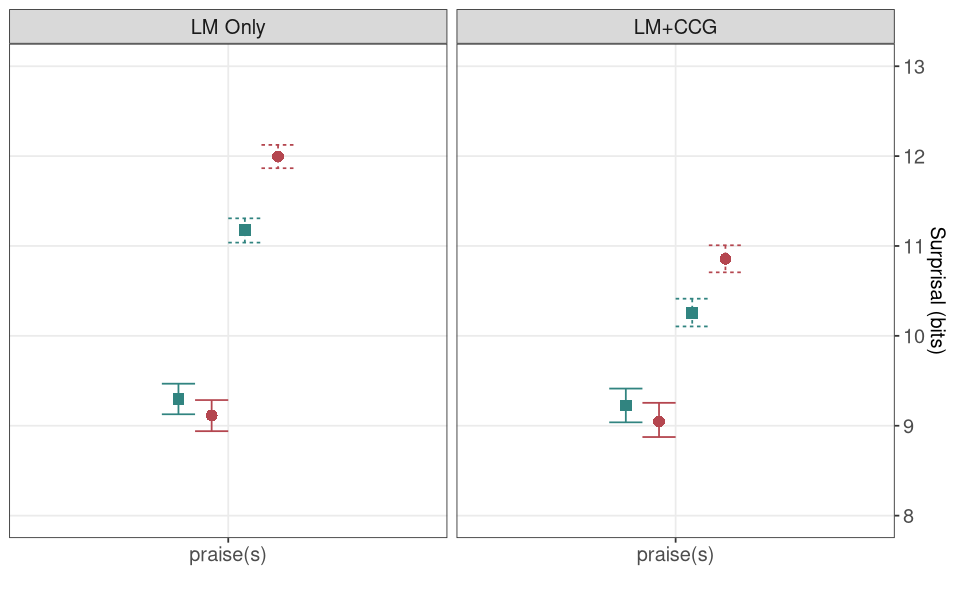

Warning message:
“Removed 3840 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 3840 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 4 rows containing missing values (geom_point).”


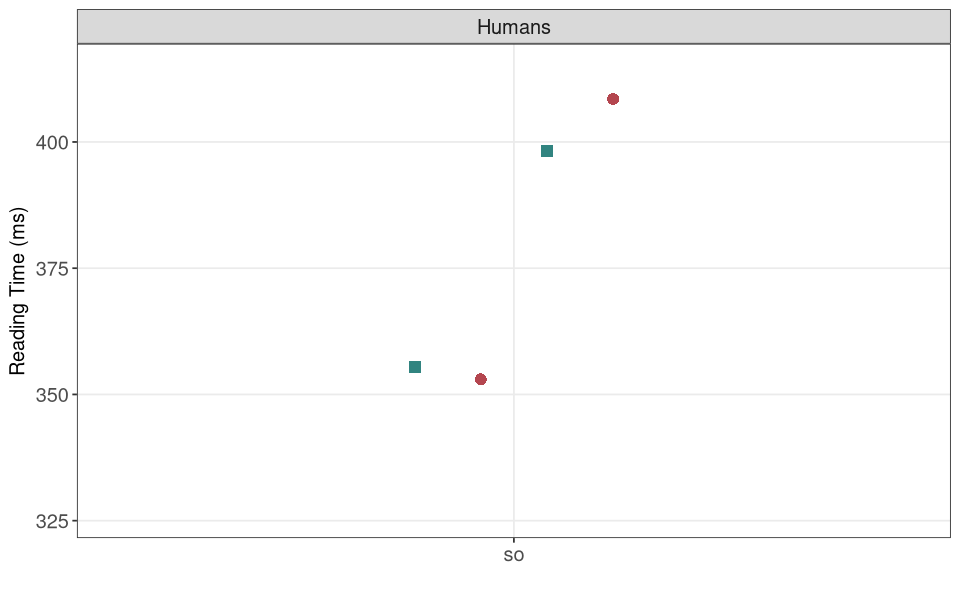

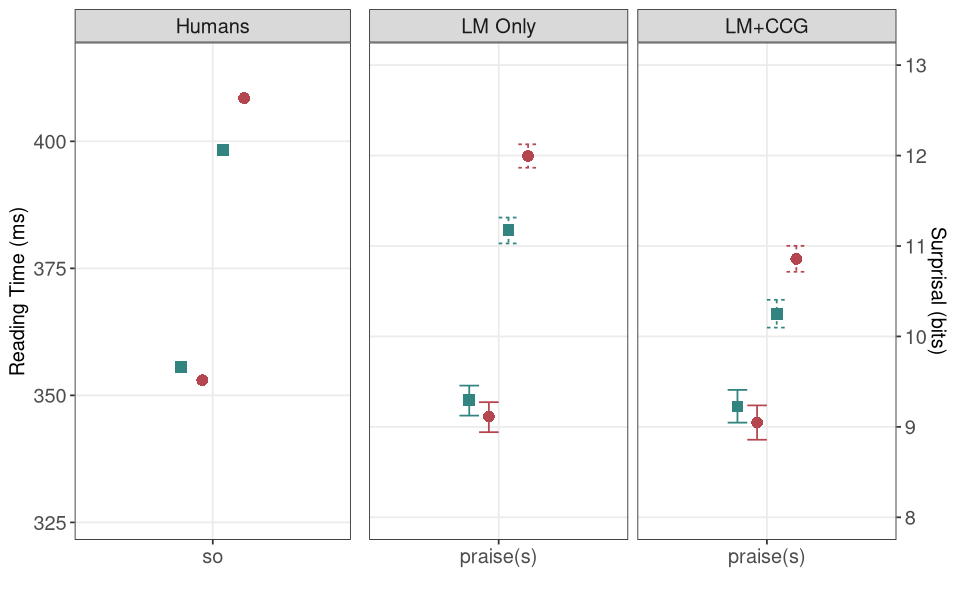

In [43]:
no_h <- c("lmaug", "augment")

plt1 <- ggplot(subset(wagers_all, type %in% no_h), aes(x=pos, y=surp, color=match,, shape=match, linetype=gram, group=interaction(match, gram))) + 
    facet_grid(.~factor(type, levels=no_h), labeller=as_labeller(c("lmaug"="LM Only",
                          "augment"="LM+CCG",
                          "wiki_lm"="LM Only \nWiki",
                          "ccglm"="LM Only \nPTB",
                          "gpt2"="GPT-2",
                          "h"="Humans")), scales="free_y") +
    stat_summary(geom="point", size=3, fun.data=mean_cl_boot, position=position_dodge(width=0.2)) +
    stat_summary(geom="errorbar", width=0.2, fun.data=mean_cl_boot, position=position_dodge(width=0.2)) +
    labs(x="", y="Surprisal (bits)", color="", shape="", linetype="") +
    scale_y_continuous(position="right") +
    scale_linetype_discrete(labels=c("G"="Grammatical", 
                                     "U"="Ungrammatical")) +
    scale_x_continuous(labels=c("The", "musician(s)", "who", "the", "_subj_", "praise(s)", "so", "highly", "will", "probably..."), breaks=0:9, limits=c(0,9)) +
    coord_cartesian(xlim=c(4.7, 5.3), ylim=c(8, 13)) +
    theme_bw() + 
    theme(axis.text.x=element_text(angle=0, size=12), axis.text.y=element_text(size=12),
          axis.title.y=element_text(size=12), axis.title.x=element_text(size=12, hjust=0),
          strip.text=element_text(size=12), legend.text=element_text(size=8), legend.position="bottom",
          panel.background=element_rect(fill="#FFFFFF"),
          panel.grid.minor=element_blank()) +
    theme(legend.position="none") +
    scale_color_manual(labels=c("FALSE"="Mismatch \n(\"The musicians\")", 
                                    "TRUE"="Match \n(\"The musician\")"), 
                           values=pallette, breaks=c(FALSE, TRUE)) + 
                     scale_shape_manual(labels=c("FALSE"="Mismatch \n(\"The musicians\")", 
                                    "TRUE"="Match \n(\"The musician\")"), 
                           values=c("TRUE"=16, "FALSE"=15), breaks=c(FALSE, TRUE)) 
plt1

plt2 <- ggplot(subset(wagers_all, type =="h"), aes(x=pos, y=surp, color=match,, shape=match, linetype=gram, group=interaction(match, gram))) + 
    facet_grid(.~factor(type, levels=c("h")), labeller=as_labeller(c("lmaug"="LM Only",
                          "augment"="LM+CCG",
                          "wiki_lm"="LM Only \nWiki",
                          "ccglm"="LM Only \nPTB",
                          "gpt2"="GPT-2",
                          "h"="Humans")), scales="free_y") +
    stat_summary(geom="point", size=3, fun.data=mean_cl_boot, position=position_dodge(width=0.2)) +
    labs(x="", y="Reading Time (ms)", color="", shape="", linetype="") +
    scale_linetype_discrete(labels=c("G"="Grammatical", 
                                     "U"="Ungrammatical")) +
    scale_x_continuous(labels=c("The", "musician(s)", "who", "the", "_subj_", "praise(s)", "so", "highly", "will", "probably..."), breaks=0:9, limits=c(0,9)) +
    coord_cartesian(xlim=c(5.7, 6.3)) +
    theme_bw() + 
    theme(axis.text.x=element_text(angle=0, size=12), axis.text.y=element_text(size=12),
          axis.title.y=element_text(size=12), axis.title.x=element_text(size=12, hjust=0),
          strip.text=element_text(size=12), legend.text=element_text(size=8), legend.position="bottom",
          panel.background=element_rect(fill="#FFFFFF"),
          panel.grid.minor=element_blank()) +
    theme(legend.position="none") +
    scale_color_manual(labels=c("FALSE"="Mismatch \n(\"The musicians\")", 
                                    "TRUE"="Match \n(\"The musician\")"), 
                           values=pallette, breaks=c(FALSE, TRUE)) + 
                     scale_shape_manual(labels=c("FALSE"="Mismatch \n(\"The musicians\")", 
                                    "TRUE"="Match \n(\"The musician\")"), 
                           values=c("TRUE"=16, "FALSE"=15), breaks=c(FALSE, TRUE)) 

plt2

p1 <- cowplot::plot_grid(plt2, plt1, rel_widths=c(3,5))
p1
ggsave("plots/Wagers_lmccglmonly.png", width=6.5, height=4)

In [40]:
plot_wagers_spr_x_m <- function(dataset, subj, verbg, verbu, xlim, ylim, no_leg=FALSE) {
    plt <- ggplot(subset(dataset, type != "h"), aes(x=pos, y=surp, color=match,, shape=match, linetype=gram, group=interaction(match, gram))) + 
    facet_grid(.~factor(type, levels=model_order), labeller=as_labeller(c("lmaug"="LM Only \nWiki+PTB",
                          "augment"="LM+CCG \nWiki+PTB",
                          "wiki_lm"="LM Only \nWiki",
                          "ccglm"="LM Only \nPTB",
                          "gpt2"="GPT-2",
                          "h"="Humans")), scales="free_y") +
    stat_summary(geom="point", size=2.3, fun.data=mean_se) +
    stat_summary(geom="line", fun.data=mean_se) +
    stat_summary(geom="errorbar", width=0.2, fun.data=mean_se) +
    labs(x=paste0("The musician(s) who the ", subj, "..."), y="Surprisal (bits)", color="", shape="", linetype="") +
    scale_linetype_discrete(labels=c("G"=paste0("Grammatical \n(\"", verbg, "\")"), 
                                     "U"=paste0("Ungrammatical \n(\"", verbu, "\")"))) +
    scale_x_continuous(labels=c("The", "musician(s)", "who", "the", subj, "praise(s)", "so", "highly", "will", "probably..."), breaks=0:9, limits=c(0,9)) +
    coord_cartesian(ylim=ylim, xlim=xlim) +
    theme_bw() + 
    theme(axis.text.x=element_text(angle=0, size=12), axis.text.y=element_text(size=12),
          axis.title.y=element_text(size=12), axis.title.x=element_text(size=12, hjust=0),
          strip.text=element_text(size=12), legend.text=element_text(size=8), legend.position="bottom",
          panel.background=element_rect(fill="#FFFFFF"),
          panel.grid.minor=element_blank())
    
    if (no_leg) {
        plt = plt + theme(legend.position="none")
    }
    
    if (subj=="reviewer") {
        plt <- plt + scale_color_manual(labels=c("FALSE"="Mismatch \n(\"The musicians\")", 
                                    "TRUE"="Match \n(\"The musician\")"), 
                           values=pallette, breaks=c(FALSE, TRUE)) + 
                     scale_shape_manual(labels=c("FALSE"="Mismatch \n(\"The musicians\")", 
                                    "TRUE"="Match \n(\"The musician\")"), 
                           values=c("TRUE"=16, "FALSE"=15), breaks=c(FALSE, TRUE)) 
    }
    else {
        plt <- plt + scale_color_manual(labels=c("FALSE"="Mismatch \n(\"The musician\")", 
                                    "TRUE"="Match \n(\"The musicians\")"), 
                           values=pallette, breaks=c(FALSE, TRUE)) + 
                     scale_shape_manual(labels=c("FALSE"="Mismatch \n(\"The musician\")", 
                                    "TRUE"="Match \n(\"The musicians\")"), 
                           values=c("TRUE"=16, "FALSE"=15), breaks=c(FALSE, TRUE)) 
    }
    
    plt
}
plot_wagers_spr_x_h <- function(dataset, subj, verbg, verbu, xlim, ylim, no_leg=FALSE) {
    plt <- ggplot(subset(dataset, type == "h"), aes(x=pos, y=surp, color=match, shape=match,
                                                    linetype=gram, group=interaction(match, gram))) + 
    facet_grid(.~factor(type, levels=model_order), labeller=as_labeller(c("lmaug"="LM Only \nWiki+PTB",
                          "augment"="LM+CCG \nWiki+PTB",
                          "wiki_lm"="LM Only \nWiki",
                          "ccglm"="LM Only \nPTB",
                          "gpt2"="GPT-2",
                          "h"="Humans\n")), scales="free_y") +
    stat_summary(geom="point", size=2.3, fun.data=mean_se) +
    stat_summary(geom="line", fun.data=mean_se) +
    stat_summary(geom="errorbar", width=0.2, fun.data=mean_se) +
    labs(x=" ", y="RT (ms)", color="", linetype="", shape="") +
    scale_linetype_discrete(labels=c("G"=paste0("Grammatical \n(\"", verbg, "\")"), 
                                     "U"=paste0("Ungrammatical \n(\"", verbu, "\")"))) +
    scale_x_continuous(labels=c("The", "musician(s)", "who", "the", subj, "praise(s)", "so", "highly", "will", "probably..."), 
                       breaks=0:9, limits=c(0,9)) +
    scale_y_continuous(position="right") +
    coord_cartesian(ylim=ylim, xlim=xlim) +
    theme_bw() + 
    theme(axis.text.x=element_text(angle=0, size=12), axis.text.y=element_text(size=12),
          axis.title.y=element_text(size=12), axis.title.x=element_text(size=12, hjust=0),
          strip.text=element_text(size=12), legend.text=element_text(size=8), legend.position="bottom",
          panel.background=element_rect(fill="#FFFFFF"),
          panel.grid.minor=element_blank())
    
    if (no_leg) {
        plt = plt + theme(legend.position="none")
    }
    
    if (subj=="reviewer") {
        plt <- plt + scale_color_manual(labels=c("FALSE"="Mismatch \n(\"The musicians\")", 
                                    "TRUE"="Match \n(\"The musician\")"), 
                           values=pallette, breaks=c(FALSE, TRUE)) +
                     scale_shape_manual(labels=c("FALSE"="Mismatch \n(\"The musicians\")", 
                                    "TRUE"="Match \n(\"The musician\")"), 
                           values=c("TRUE"=16, "FALSE"=15), breaks=c(FALSE, TRUE))
    }
    else {
        plt <- plt + scale_color_manual(labels=c("FALSE"="Mismatch \n(\"The musician\")", 
                                    "TRUE"="Match \n(\"The musicians\")"), 
                           values=pallette, breaks=c(FALSE, TRUE)) +
                     scale_shape_manual(labels=c("FALSE"="Mismatch \n(\"The musician\")", 
                                    "TRUE"="Match \n(\"The musicians\")"), 
                           values=c("TRUE"=16, "FALSE"=15), breaks=c(FALSE, TRUE))
    }
    
    plt
}

plot_wagers_spr_x <- function(dataset, subject, verbg, verbu, xlim_m, xlim_h, ylim_m, ylim_h) {
    plt_m <- plot_wagers_spr_x_m(dataset, subject, verbg, verbu, xlim_m, ylim_m, no_leg=TRUE)
    plt_h <- plot_wagers_spr_x_h(dataset, subject, verbg, verbu, xlim_h, ylim_h, no_leg=TRUE)
    plt_leg <- plot_wagers_spr_x_m(dataset, subject, verbg, verbu, xlim_m, ylim_m, no_leg=FALSE)
    p1 <- cowplot::plot_grid(plt_m, plt_h, rel_widths=c(3,3))
    
    leg <- get_legend(plt_leg)
    
    cowplot::plot_grid(p1, leg, rel_heights=c(1, 0.1), ncol=1) + 
    theme(plot.background=element_rect(fill="white", color="white"))
}

Warning message:
“Removed 2112 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 2112 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 2112 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 2112 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 2112 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 2112 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 2112 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 2112 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 2112 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 2112 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 2112 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 2112 rows containing non-finite values (stat_summary).”


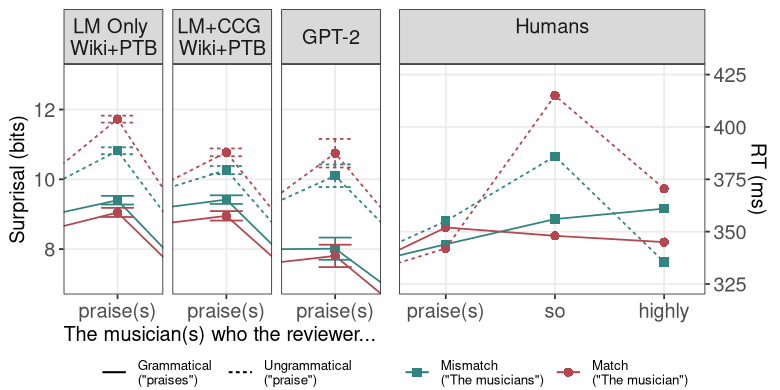

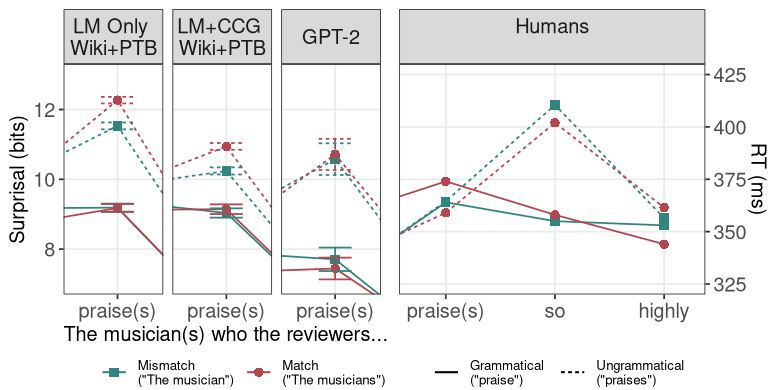

In [41]:
options(repr.plot.width=6.5, repr.plot.height=3.25)

#no lmonly wiki! 
wagers_all <- subset(wagers_all, !(wagers_all$type %in% ignore))

plot_wagers_spr_x(subset(wagers_all, subj=="S"), 
                "reviewer", "praises", "praise", c(4.7,5.25), c(4.7,7.25), c(7,13), c(325, 425))
ggsave("plots/Wagers_Ssubj_popout.png", width=6.5, height=3.25)


plot_wagers_spr_x(subset(wagers_all, subj=="P"), 
                "reviewers", "praise", "praises", c(4.7,5.25), c(4.7,7.25), c(7,13), c(325, 425))
ggsave("plots/Wagers_Psubj_popout.png", width=6.5, height=3.25)


In [47]:
plot_wagers_spr_y_m <- function(dataset, subj, verbg, verbu, xlim, ylim, no_leg=FALSE) {
    plt <- ggplot(subset(dataset, type != "h"), aes(x=pos, y=surp, color=match, shape=match, linetype=gram, group=interaction(match, gram))) + 
    facet_grid(factor(type, levels=model_order)~., labeller=as_labeller(c("lmaug"="LM Only \nWiki+PTB",
                          "augment"="LM+CCG \nWiki+PTB",
                          "wiki_lm"="LM Only \nWiki",
                          "ccglm"="LM Only \nPTB",
                          "gpt2"="GPT-2",
                          "h"="Humans\n")), scales="free_y") +
    stat_summary(geom="point", size=2.3, fun.data=mean_se) +
    stat_summary(geom="line", fun.data=mean_se) +
    stat_summary(geom="errorbar", width=0.2, fun.data=mean_se, size=0.7) +
    labs(x="", y="Surprisal (bits)", color="", linetype="", shape="") +
    scale_linetype_discrete(labels=c("G"=paste0("Grammatical \n(\"", verbg, "\")"), 
                                     "U"=paste0("Ungrammatical \n(\"", verbu, "\")"))) +
    scale_x_continuous(labels=c("The", "musician(s)", "who", "the", subj, "praise(s)", "so", "highly", "will", "probably..."), breaks=0:9, limits=c(0,9)) +
    coord_cartesian(ylim=ylim, xlim=xlim) +
    theme_bw() + 
    theme(axis.text.x=element_text(angle=45, hjust=1, size=12), axis.text.y=element_text(size=12),
          axis.title.y=element_text(size=12), axis.title.x=element_text(size=13, hjust=0),
          strip.text=element_text(size=12), legend.text=element_text(size=8), 
          panel.grid.minor=element_blank(), legend.position="top")
    
    if (no_leg) {
        plt = plt + theme(legend.position="none")
    }
    
    if (subj=="reviewer") {
        plt <- plt + scale_color_manual(labels=c("FALSE"="Mismatch \n(\"The musicians\")", 
                                    "TRUE"="Match \n(\"The musician\")"), 
                           values=pallette, breaks=c(FALSE, TRUE)) +
                     scale_shape_manual(labels=c("FALSE"="Mismatch \n(\"The musicians\")", 
                                    "TRUE"="Match \n(\"The musician\")"), 
                           values=c("TRUE"=16, "FALSE"=15), breaks=c(FALSE, TRUE))
    }
    else {
        plt <- plt + scale_color_manual(labels=c("FALSE"="Mismatch \n(\"The musician\")", 
                                    "TRUE"="Match \n(\"The musicians\")"), 
                           values=pallette, breaks=c(FALSE, TRUE)) + 
                     scale_shape_manual(labels=c("FALSE"="Mismatch \n(\"The musician\")", 
                                    "TRUE"="Match \n(\"The musicians\")"), 
                           values=c("TRUE"=16, "FALSE"=15), breaks=c(FALSE, TRUE))
    }
    plt
}
plot_wagers_spr_y_h <- function(dataset, subj, verbg, verbu, xlim, ylim, no_leg=FALSE) {
    plt <- ggplot(subset(dataset, type == "h"), aes(x=pos, y=surp, color=match, shape=match, linetype=gram, group=interaction(match, gram))) + 
    facet_grid(factor(type, levels=model_order)~., labeller=as_labeller(c("lmaug"="LM Only \nWiki+PTB",
                          "augment"="LM+CCG \nWiki+PTB",
                          "wiki_lm"="LM Only \nWiki",
                          "ccglm"="LM Only \nPTB",
                          "gpt2"="GPT-2",
                          "h"="Humans\n")), scales="free_y") +
    stat_summary(geom="point", size=2.3, fun.data=mean_se) +
    stat_summary(geom="line", fun.data=mean_se, size=0.7) +
    stat_summary(geom="errorbar", width=0.2, fun.data=mean_se) +
    labs(x=" ", y="RT (ms)", color="", linetype="", shape="") +
    scale_linetype_discrete(labels=c("G"=paste0("Grammatical \n(\"", verbg, "\")"), 
                                     "U"=paste0("Ungrammatical \n(\"", verbu, "\")"))) +scale_x_continuous(labels=c("The", "musician(s)", "who", "the", subj, "praise(s)", "so", "highly", "will", "probably..."), breaks=0:9, limits=c(0,9)) +
    coord_cartesian(ylim=ylim, xlim=xlim) +
    theme_bw() + 
    theme(axis.text.x=element_text(angle=45, hjust=1, size=12), axis.text.y=element_text(size=12),
          axis.title.y=element_text(size=12), axis.title.x=element_text(size=12, hjust=0),
          strip.text=element_text(size=12), legend.text=element_text(size=8), 
          panel.grid.minor=element_blank(), legend.position="top")
    
    if (subj=="reviewer") {
        plt <- plt + scale_color_manual(labels=c("FALSE"="Mismatch \n(\"The musicians\")", 
                                    "TRUE"="Match \n(\"The musician\")"), 
                           values=pallette, breaks=c(FALSE, TRUE)) + 
                     scale_shape_manual(labels=c("FALSE"="Mismatch \n(\"The musicians\")", 
                                    "TRUE"="Match \n(\"The musician\")"), 
                           values=c("TRUE"=16, "FALSE"=15), breaks=c(FALSE, TRUE)) 
    }
    else {
        plt <- plt + scale_color_manual(labels=c("FALSE"="Mismatch \n(\"The musician\")", 
                                    "TRUE"="Match \n(\"The musicians\")"), 
                           values=pallette, breaks=c(FALSE, TRUE)) + 
                     scale_shape_manual(labels=c("FALSE"="Mismatch \n(\"The musician\")", 
                                    "TRUE"="Match \n(\"The musicians\")"), 
                           values=c("TRUE"=16, "FALSE"=15), breaks=c(FALSE, TRUE)) 
    }
    if (no_leg) {
        plt = plt + theme(legend.position="none")
    }
    plt
}

plot_wagers_spr_y <- function(dataset, subject, verbg, verbu,  ylim_m, ylim_h) {
    plt_m <- plot_wagers_spr_y_m(dataset, subject, verbg, verbu, c(0,9), ylim_m)
    plt_h <- plot_wagers_spr_y_h(dataset, subject, verbg, verbu, c(4,7), ylim_h, no_leg=TRUE)
    cowplot::plot_grid(plt_m, cowplot::plot_grid(NULL, plt_h, NULL, rel_widths=c(1, 1.10,0.53), ncol=3), 
                       ncol=1, rel_heights=c(1, 0.55))  + 
    theme(plot.background=element_rect(fill="white", color="white"))
    
}

Warning message:
“Removed 2112 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 2112 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 2112 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 2112 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 2112 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 2112 rows containing non-finite values (stat_summary).”


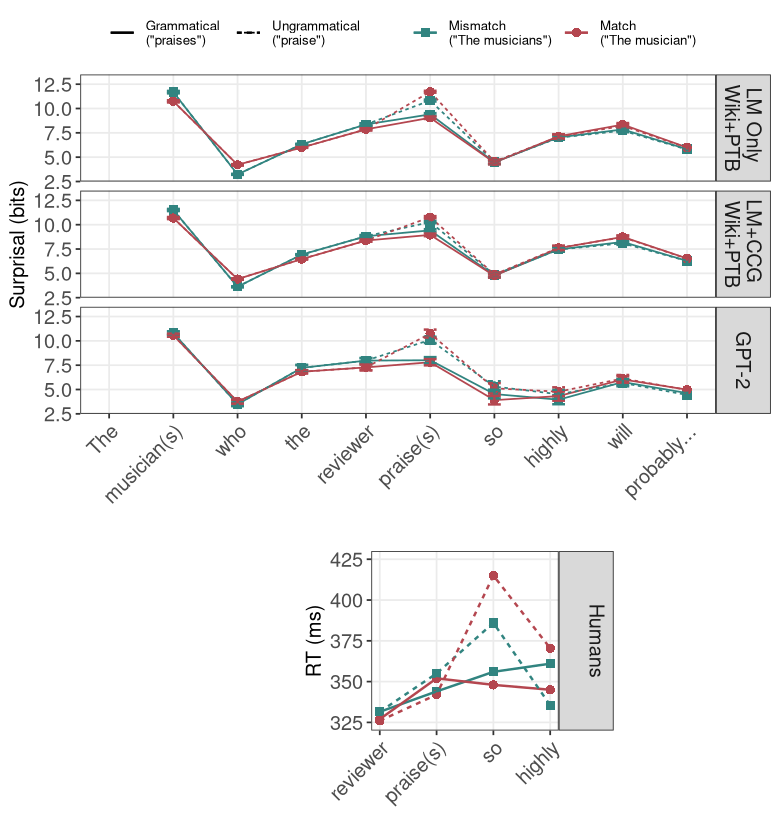

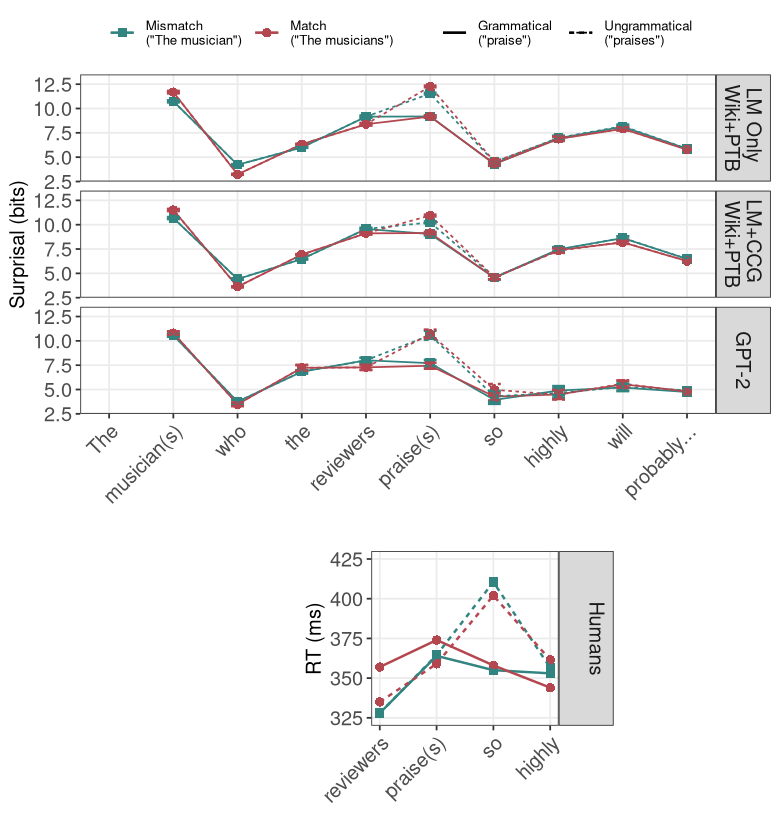

In [48]:
options(repr.plot.width=6.5, repr.plot.height=7)

plot_wagers_spr_y(subset(wagers_all, subj=="S"), 
                "reviewer", "praises", "praise", c(3,13), c(325, 425))
ggsave("plots/Wagers_Ssubj_all.png", width=6.5, height=7)


plot_wagers_spr_y(subset(wagers_all, subj=="P"), 
                "reviewers", "praise", "praises", c(3,13), c(325, 425))
ggsave("plots/Wagers_Psubj_all.png", width=6.5, height=7)


In [70]:
wagers_df_verb <- subset(wagers_df, pos == 5)

wagers_lm <- lmer(data=subset(wagers_df_verb, wagers_df_verb$type == "lmaug" & wagers_df_verb$gram == "G"), 
                 surp ~ match + (1|item) + (1 | model))

summary(wagers_lm)

wagers_lm <- lmer(data=subset(wagers_df_verb, wagers_df_verb$type == "lmaug" & wagers_df_verb$gram == "U"), 
                 surp ~ match+ (1|item) + (1 | model))


summary(wagers_lm)

wagers_lm <- lmer(data=subset(wagers_df_verb, wagers_df_verb$type == "lmaug"), 
                 surp ~ vmatch * gram + (1|item) + (1 | model))

summary(wagers_lm)

wagers_lm <- lmer(data=subset(wagers_df_verb, wagers_df_verb$type == "augment" & wagers_df_verb$gram == "G"), 
                 surp ~ match + (1|item) + (1 | model))

summary(wagers_lm)

wagers_lm <- lmer(data=subset(wagers_df_verb, wagers_df_verb$type == "augment" & wagers_df_verb$gram == "U"), 
                 surp ~ match+ (1|item) + (1 | model))


summary(wagers_lm)

wagers_lm <- lmer(data=subset(wagers_df_verb, wagers_df_verb$type == "augment"), 
                 surp ~ vmatch * gram + (1|item) + (1 | model))

summary(wagers_lm)

wagers_lm <- lmer(data=subset(wagers_df_verb), 
                 surp ~ type * vmatch * gram + (1|item) + (1 | model))

summary(wagers_lm)

wagers_lm <- lmer(data=subset(wagers_df_verb, wagers_df_verb$type == "gpt2"& wagers_df_verb$gram == "G"), 
                 surp ~ match  + (1|item))

summary(wagers_lm)

wagers_lm <- lmer(data=subset(wagers_df_verb, wagers_df_verb$type == "gpt2"& wagers_df_verb$gram == "U"), 
                 surp ~ match  + (1|item))

summary(wagers_lm)

wagers_lm <- lmer(data=subset(wagers_df_verb, wagers_df_verb$type == "gpt2"& wagers_df_verb$gram == "U" & wagers_df_verb$subj == "S"), 
                 surp ~ match  + (1|item))

summary(wagers_lm)

wagers_lm <- lmer(data=subset(wagers_df_verb, wagers_df_verb$type == "gpt2"), 
                 surp ~ vmatch * gram + (1|item))

summary(wagers_lm)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: surp ~ match + (1 | item) + (1 | model)
   Data: 
subset(wagers_df_verb, wagers_df_verb$type == "lmaug" & wagers_df_verb$gram ==  
    "G")

REML criterion at convergence: 2664.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1897 -0.6739 -0.0439  0.5647  3.7635 

Random effects:
 Groups   Name        Variance Std.Dev.
 item     (Intercept) 2.72801  1.6517  
 model    (Intercept) 0.09992  0.3161  
 Residual             0.74495  0.8631  
Number of obs: 960, groups:  item, 48; model, 5

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   9.29439    0.27995  34.43485  33.201   <2e-16 ***
matchTRUE    -0.17971    0.05571 906.99999  -3.226   0.0013 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
          (Intr)
matchTRUE -0.100

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: surp ~ match + (1 | item) + (1 | model)
   Data: 
subset(wagers_df_verb, wagers_df_verb$type == "lmaug" & wagers_df_verb$gram ==  
    "U")

REML criterion at convergence: 2933.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6850 -0.6129  0.0068  0.6277  3.2220 

Random effects:
 Groups   Name        Variance Std.Dev.
 item     (Intercept) 1.30363  1.1418  
 model    (Intercept) 0.06023  0.2454  
 Residual             1.04169  1.0206  
Number of obs: 960, groups:  item, 48; model, 5

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)  11.17323    0.20341  28.49358   54.93   <2e-16 ***
matchTRUE     0.82232    0.06588 907.00000   12.48   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
          (Intr)
matchTRUE -0.162

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: surp ~ vmatch * gram + (1 | item) + (1 | model)
   Data: subset(wagers_df_verb, wagers_df_verb$type == "lmaug")

REML criterion at convergence: 5850.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.0086 -0.6129 -0.0196  0.5952  4.2121 

Random effects:
 Groups   Name        Variance Std.Dev.
 item     (Intercept) 1.82730  1.3518  
 model    (Intercept) 0.05585  0.2363  
 Residual             1.09772  1.0477  
Number of obs: 1920, groups:  item, 48; model, 5

Fixed effects:
                   Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)         9.29439    0.22699   40.08250  40.946  < 2e-16 ***
vmatchTRUE         -0.17971    0.06763 1865.00000  -2.657  0.00795 ** 
gramU               2.70116    0.06763 1865.00000  39.940  < 2e-16 ***
vmatchTRUE:gramU   -0.64261    0.09564 1865.00000  -6.719 2.43e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: surp ~ match + (1 | item) + (1 | model)
   Data: 
subset(wagers_df_verb, wagers_df_verb$type == "augment" & wagers_df_verb$gram ==  
    "G")

REML criterion at convergence: 2777.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9815 -0.6486 -0.0213  0.5811  4.5503 

Random effects:
 Groups   Name        Variance Std.Dev.
 item     (Intercept) 3.45097  1.8577  
 model    (Intercept) 0.04164  0.2041  
 Residual             0.83649  0.9146  
Number of obs: 960, groups:  item, 48; model, 5

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   9.22590    0.28630  50.20595  32.225  < 2e-16 ***
matchTRUE    -0.17803    0.05904 906.99999  -3.016  0.00264 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
          (Intr)
matchTRUE -0.103

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: surp ~ match + (1 | item) + (1 | model)
   Data: 
subset(wagers_df_verb, wagers_df_verb$type == "augment" & wagers_df_verb$gram ==  
    "U")

REML criterion at convergence: 2764.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8186 -0.6234  0.0021  0.5552  5.0366 

Random effects:
 Groups   Name        Variance Std.Dev.
 item     (Intercept) 1.89878  1.3780  
 model    (Intercept) 0.04768  0.2184  
 Residual             0.84939  0.9216  
Number of obs: 960, groups:  item, 48; model, 5

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)  10.25175    0.22553  41.76147   45.46   <2e-16 ***
matchTRUE     0.60505    0.05949 907.00027   10.17   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
          (Intr)
matchTRUE -0.132

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: surp ~ vmatch * gram + (1 | item) + (1 | model)
   Data: subset(wagers_df_verb, wagers_df_verb$type == "augment")

REML criterion at convergence: 5569.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4499 -0.6385 -0.0013  0.5841  4.5563 

Random effects:
 Groups   Name        Variance Std.Dev.
 item     (Intercept) 2.5834   1.6073  
 model    (Intercept) 0.0400   0.2000  
 Residual             0.9364   0.9677  
Number of obs: 1920, groups:  item, 48; model, 5

Fixed effects:
                   Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)         9.22590    0.25253   50.35420  36.534  < 2e-16 ***
vmatchTRUE         -0.17803    0.06246 1865.00001  -2.850  0.00442 ** 
gramU               1.63090    0.06246 1865.00001  26.109  < 2e-16 ***
vmatchTRUE:gramU   -0.42702    0.08834 1865.00001  -4.834 1.45e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 


Correlation matrix not shown by default, as p = 20 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: surp ~ type * vmatch * gram + (1 | item) + (1 | model)
   Data: subset(wagers_df_verb)

REML criterion at convergence: 24733.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.7328 -0.5747 -0.0055  0.5655  4.6849 

Random effects:
 Groups   Name        Variance Std.Dev.
 item     (Intercept) 1.92985  1.3892  
 model    (Intercept) 0.03507  0.1873  
 Residual             1.40230  1.1842  
Number of obs: 7680, groups:  item, 48; model, 20

Fixed effects:
                                    Estimate Std. Error         df t value
(Intercept)                        9.226e+00  2.239e-01  6.495e+01  41.202
typeaugment_tied                   1.524e-01  1.495e-01  2.469e+01   1.020
typegpt2                          -1.366e+00  2.441e-01  2.469e+01  -5.596
typelmaug                          6.848e-02  1.410e-01  2.469e+01   0.486
typewiki_lm                       -1.134e-01  1.410e-01  2

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: surp ~ match + (1 | item)
   Data: 
subset(wagers_df_verb, wagers_df_verb$type == "gpt2" & wagers_df_verb$gram ==  
    "G")

REML criterion at convergence: 766.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5134 -0.3766 -0.0263  0.3422  2.8294 

Random effects:
 Groups   Name        Variance Std.Dev.
 item     (Intercept) 3.056    1.748   
 Residual             1.920    1.386   
Number of obs: 192, groups:  item, 48

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)   7.8596     0.2893  60.2598  27.172   <2e-16 ***
matchTRUE    -0.2351     0.2000 143.0000  -1.176    0.242    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
          (Intr)
matchTRUE -0.346

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: surp ~ match + (1 | item)
   Data: 
subset(wagers_df_verb, wagers_df_verb$type == "gpt2" & wagers_df_verb$gram ==  
    "U")

REML criterion at convergence: 871.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8370 -0.3657 -0.0078  0.4351  2.8964 

Random effects:
 Groups   Name        Variance Std.Dev.
 item     (Intercept) 4.676    2.162   
 Residual             3.452    1.858   
Number of obs: 192, groups:  item, 48

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)  10.3391     0.3652  62.2900  28.309   <2e-16 ***
matchTRUE     0.3912     0.2682 143.0000   1.459    0.147    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
          (Intr)
matchTRUE -0.367

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: surp ~ match + (1 | item)
   Data: 
subset(wagers_df_verb, wagers_df_verb$type == "gpt2" & wagers_df_verb$gram ==  
    "U" & wagers_df_verb$subj == "S")

REML criterion at convergence: 416.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6620 -0.1783  0.0424  0.3217  2.7917 

Random effects:
 Groups   Name        Variance Std.Dev.
 item     (Intercept) 4.697    2.167   
 Residual             1.843    1.358   
Number of obs: 96, groups:  item, 48

Fixed effects:
            Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)  10.1015     0.3691 62.0156  27.366   <2e-16 ***
matchTRUE     0.6465     0.2771 47.0000   2.333    0.024 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
          (Intr)
matchTRUE -0.375

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: surp ~ vmatch * gram + (1 | item)
   Data: subset(wagers_df_verb, wagers_df_verb$type == "gpt2")

REML criterion at convergence: 1633.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2093 -0.4956  0.0312  0.5839  2.9024 

Random effects:
 Groups   Name        Variance Std.Dev.
 item     (Intercept) 3.453    1.858   
 Residual             3.095    1.759   
Number of obs: 384, groups:  item, 48

Fixed effects:
                 Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)        7.8596     0.3228  78.6888  24.351   <2e-16 ***
vmatchTRUE        -0.2351     0.2539 333.0000  -0.926    0.355    
gramU              2.8707     0.2539 333.0000  11.305   <2e-16 ***
vmatchTRUE:gramU  -0.1561     0.3591 333.0000  -0.435    0.664    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr) vmTRUE gramU 
vmatchTRUE